In [2]:
library(data.table)
library(ggplot2)
library(dplyr)
#library(viridis)
library(qqman)
#library(qvalue)
#library(Bioconducter)
library(topGO)
"%!in%" <- function(x,table) match(x,table, nomatch = 0) == 0


Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min

Loading required p

__make a sites file to filter out linked loci with pcangsd__

In [ ]:
#how do maf and calls across ind look- also make sites files for angsd and filter sites for pcangsd
sites <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/appc_angsd_probs.hwe.gz")
#head(sites)
unlinked <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/ngsld/appc_unlinked_for_angsd.txt")
setnames(unlinked, 1:2, c("Chromo", "Position"))
unlinked[, filter := 1] #when ngsld has kept the site, mark with 1 so pcangsd knows to keep it
test_filter_sites <- left_join(sites, unlinked) #join with full sites dt and mark linked  sites with 0
#head(test_filter_sites)
#nrow(test_filter_sites)==nrow(sites) #check that this is true
test_filter_sites[is.na(filter), filter := 0]
#write out for pcangsd
#fwrite(test_filter_sites[,.(filter)], "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/ngsld/filter_linked_sites_pcangsd.txt", col.names = F)

__make positions file for angsd to restrict to unlinked sites__

In [ ]:
nrow(maf[, .N, by="chromo"])
pyam <- unique(maf[chromo %like% "PYAM"], by="chromo")[, chromo] #add the PYAM sites together
names <- maf[chromo %!in% pyam, .N, by="chromo"][, "chromo"] #get a list of chromosome labels
names_with_pyam <- rbind(names, matrix(nrow=1, ncol=1, "PYAM"), use.names=F)
#fwrite(names_with_pyam, "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/ngsld/chromosomes.txt", col.names =F)

__plot the pcangsd results, color by phenotypes in the association__

In [2]:
pca <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/output.pcangsd.cov")
#get eigenvalues
ev <-eigen(pca)
ev_dt <- data.table(ev$vectors[,1:10])
setnames(ev_dt, c("pc1", "pc2", "pc3", "pc4", "pc5", "pc6", "pc7", "pc8", "pc9", "pc10"))
#variance explained?
ev$values/sum(ev$values)

[1] 0.221901770 0.005986433 0.005971992 0.005970720 0.005946961 0.005897123
  [7] 0.005888754 0.005856908 0.005849885 0.005830119 0.005822542 0.005804274
 [13] 0.005774534 0.005766451 0.005756114 0.005753626 0.005750554 0.005746207
 [19] 0.005743890 0.005737366 0.005736879 0.005735947 0.005730919 0.005724538
 [25] 0.005723702 0.005720938 0.005715563 0.005705724 0.005704918 0.005700965
 [31] 0.005694457 0.005668299 0.005663375 0.005658731 0.005648217 0.005639823
 [37] 0.005620841 0.005620312 0.005613650 0.005609061 0.005590250 0.005588762
 [43] 0.005585388 0.005568958 0.005561200 0.005530672 0.005529138 0.005513271
 [49] 0.005504987 0.005497439 0.005487145 0.005462854 0.005458941 0.005447962
 [55] 0.005432130 0.005415444 0.005397950 0.005372495 0.005364970 0.005310600
 [61] 0.005283213 0.005244973 0.005230800 0.005218218 0.005190391 0.005012499
 [67] 0.004991066 0.004978531 0.004929657 0.004911353 0.004903439 0.004878348
 [73] 0.004861031 0.004853725 0.004850291 0.004838124 0.004830776 0.004825253
 [79] 0.004819311 0.004805304 0.004788511 0.004776908 0.004770615 0.004760303
 [85] 0.004755681 0.004750463 0.004741221 0.004718760 0.004717716 0.004686732
 [91] 0.004679649 0.004633633 0.004624449 0.004611324 0.004603890 0.004583634
 [97] 0.004577706 0.004573393 0.004566898 0.004560917 0.004551655 0.004535983
[103] 0.004525968 0.004517399 0.004507834 0.004499793 0.004487312 0.004461839
[109] 0.004443602 0.004441220 0.004436501 0.004433475 0.004428614 0.004425940
[115] 0.004409216 0.004407109 0.004387074 0.004372304 0.004364221 0.004348571
[121] 0.004343991 0.004340042 0.004322838 0.004315929 0.004292349 0.004289138
[127] 0.004270876 0.004268804 0.004262863 0.004256193 0.004244851 0.004238826
[133] 0.004233425 0.004232243 0.004224253 0.004220387 0.004217491 0.004209353
[139] 0.004203756 0.004198352 0.004194363 0.004186259 0.004184298 0.004182210
[145] 0.004174825 0.004169643 0.004158900 0.004130370 0.004121254 0.004115755
[151] 0.004070559 0.004042691 0.004019740 0.003952630 0.003941130 0.003912974
[157] 0.003872655 0.003807733 0.003638070

__join together the metadata with other covariates and phenotypes with the pcs- be sure to check that the samples are ordered the same as bamlist__

In [3]:
bamlist <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/bamlist.list.txt")
meta <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/Sample_Meta.txt")[is.na(Group), Group :=-999][Group=="High", Group:=1][Group=="Low", Group:=0][, .(sample=gen_id, ucrit=Ucrit, sl=SL, dam, sire, case=Group, capture=Capture)]
sorted_meta <- left_join(bamlist, meta, by="sample")
pca_phenos <- cbind(sorted_meta , ev_dt)[, sequencing_lib := ifelse(capture %in% c("Pop01","Pop02","Pop03", "Pop04", "Pop05", "Pop06", "Pop07","Pop08"), 1, 2)]
#write out the pcs to use as covariates
#fwrite(pca_phenos[, "capture"], "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/capture.cov", col.names = F)

Warning message in `[.data.table`(fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/Sample_Meta.txt")[is.na(Group), :
“Coerced double RHS to character to match the type of the target column (column 10 named 'Group'). If the target column's type character is correct, it's best for efficiency to avoid the coercion and create the RHS as type character. To achieve that consider R's type postfix: typeof(0L) vs typeof(0), and typeof(NA) vs typeof(NA_integer_) vs typeof(NA_real_). You can wrap the RHS with as.character() to avoid this warning, but that will still perform the coercion. If the target column's type is not correct, it's best to revisit where the DT was created and fix the column type there; e.g., by using colClasses= in fread(). Otherwise, you can change the column type now by plonking a new column (of the desired type) over the top of it; e.g. DT[, `Group`:=as.double(`Group`)]. If the RHS of := has nrow(DT) elements then the assignment is called a c

In [56]:
predictors <- as.data.table(summary(glm(data=pca_pheno_unlinked, ucrit ~ V1+V2+V3))$coeff)
 
predictors$names <- row.names(summary(glm(data=pca_pheno_unlinked, ucrit ~ V1+V2+V3))$coeff)
setnames(predictors, 4, "pvalue")
predictors[pvalue <0.08][order(pvalue)]

Estimate,Std. Error,t value,pvalue,names
4.077585,0.2397162,17.01005,2.820919e-37,(Intercept)


In [54]:
#what pcs/covariates explain the phenotype?
predictors <- as.data.table(summary(glm(data=pca_pheno_unlinked, sl ~ V1+V2+V3))$coeff)
 
predictors$names <- row.names(summary(glm(data=pca_pheno_unlinked, sl ~ V1+V2+V3))$coeff)
setnames(predictors, 4, "pvalue")
predictors[pvalue <0.06][order(pvalue)]

Estimate,Std. Error,t value,pvalue,names
4.2565577,0.01110523,383.293050,2.851757e-217,(Intercept)
-0.2634892,0.13867298,-1.900076,5.943614e-02,V1


In [ ]:
#fwrite(pca_phenos[,.(pc1, pc2, pc3)],"/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/pc1-3_unlinked.cov", col.names = FALSE )

In [392]:
str(pca_phenos)

Classes ‘data.table’ and 'data.frame':	159 obs. of  18 variables:
 $ sample        : chr  "Pop01_APPC1611" "Pop01_APPC1917" "Pop01_APPC1921" "Pop01_APPC2029" ...
 $ ucrit         : num  8.13 1.2 7.33 8.82 7.32 5.07 6.33 1.8 0.3 1.17 ...
 $ sl            : num  4.4 4.35 4.28 4.25 4.54 3.94 4.29 4.36 4.43 4.35 ...
 $ dam           : chr  "D125" "D85" "D85" "D70" ...
 $ sire          : chr  "S144" "S173" "S173" "S98" ...
 $ case          : chr  "1" "0" "1" "1" ...
 $ capture       : chr  "Pop01" "Pop01" "Pop01" "Pop01" ...
 $ pc1           : num  -0.0926 -0.11195 0.00391 -0.03316 0.02408 ...
 $ pc2           : num  -0.006637 -0.013639 -0.000324 -0.119551 -0.000398 ...
 $ pc3           : num  0.005136 0.008223 -0.000178 0.533403 -0.000211 ...
 $ pc4           : num  0.01451 -0.003482 -0.000424 -0.833042 -0.001329 ...
 $ pc5           : num  0.037122 0.013261 -0.000944 -0.056651 -0.002514 ...
 $ pc6           : num  -0.02155 -0.00495 0.00035 0.005 0.00082 ...
 $ pc7           : num  -0.0911

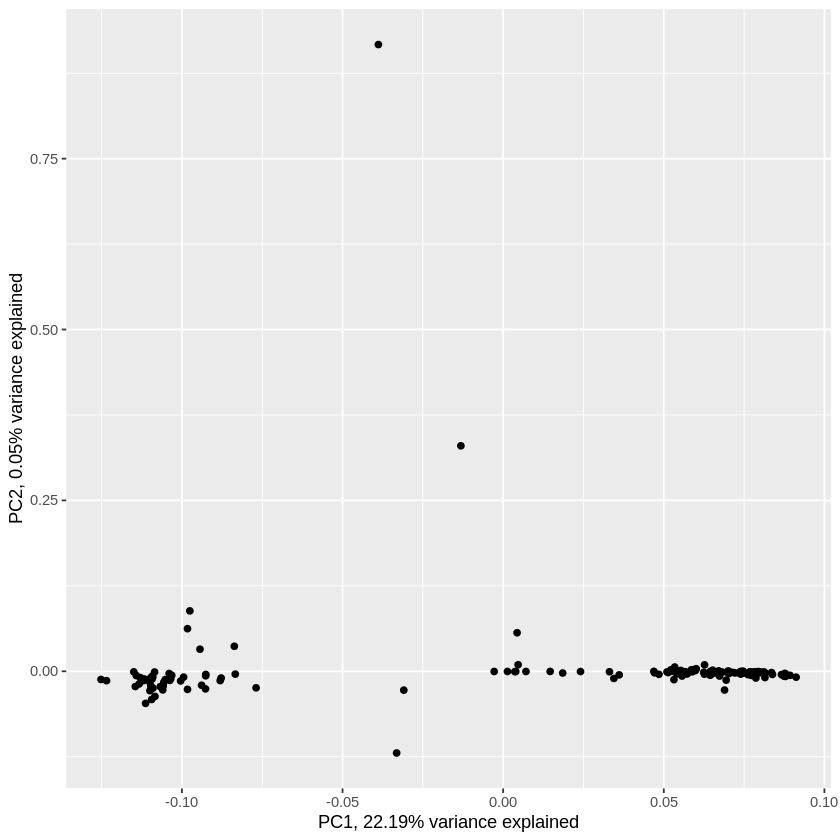

In [4]:
pca_plot <- ggplot(data=pca_phenos, aes(x=pc1, y=pc2))+
    geom_point()+
    xlab("PC1, 22.19% variance explained")+
    ylab("PC2, 0.05% variance explained")
pca_plot

In [5]:
ggsave(plot=pca_plot, filename = "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/pca.pdf")

Saving 6.67 x 6.67 in image


In [ ]:
#ggplot()+
#    geom_point(data=pca_phenos[], aes(x=pc1, y=pc2, col=sl)) +
#    scale_color_viridis(color.palette=magma)

In [ ]:
#ggplot()+
#    geom_point(data=pca_phenos, aes(x=pc1, y=pc2, col=ucrit)) +
#    scale_color_viridis(option="magma")

In [ ]:
#ggplot()+
#    geom_point(data=pca_phenos, aes(x=pc1, y=pc2, col=sequencing_lib)) +
#    scale_color_viridis(option="magma")

In [ ]:
ggplot(data=pca_phenos, aes(x=pc1, y=pc2, col=dam, label=sample))+
    geom_point() #+
    #geom_text(nudge_x = 0.02)

### evaluate model and plot GWAS results for each phenotype

In [3]:
lrt_ucrit <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/ucrit_assoc5_maf0.05_noMaxdepth_minQ30_minCount16.lrt0.gz")
lrt_ucrit[, locus := paste(Chromosome, Position, sep=":")]
setnames(lrt_ucrit, "LRTscore", "LRT")

#filter out loci in hwe and NAN
lrt_filt_ucrit <- lrt_ucrit[LRT>0]#[,Chromosome := paste0("chr", Chromosome, sep="")] #uncomment this for the top go analysis
#lrt_filt <- lrt[LRT>0]
#format for manhattan plot
#get pvalues
lrt_filt_ucrit$pvalue<-dchisq(lrt_filt_ucrit$LRT, df=1)
lrt_filt_ucrit[, Chromosome := gsub(".","", Chromosome, fixed = T)][, Chromosome := gsub("CM","", Chromosome, fixed = T)][, Chromosome := gsub("PYAM","", Chromosome, fixed = T)]
lrt_filt_ucrit[, Chromosome := as.numeric(Chromosome)]
lrt_filt_ucrit$SNP<-paste("r",1:length(lrt_filt_ucrit$Chromosome), sep="")


lrt_filt_ucrit <- lrt_filt_ucrit[order(LRT)][,quantile:=1:nrow(lrt_filt_ucrit)/nrow(lrt_filt_ucrit)] #quantiles for observed lrt
exp_lrt_ucrit <- data.table( exp_lrt = rchisq(nrow(lrt_filt_ucrit), 1))[order(exp_lrt)]
lrt_filt_ucrit$exp_lrt_ucrit <-exp_lrt_ucrit[, exp_lrt]


In [176]:
tail(lrt_filt_ucrit)

Chromosome,Position,Major,Minor,Frequency,N,LRT,high_WT/HE/HO,LRTem,beta,SE,emIter,locus,pvalue,SNP,quantile,exp_lrt_ucrit
13,1154707,C,A,0.095582,159,13.45818,69/10/0,13.54872,3.192640,1.335931,10,13:1154707,0.00013001982,r71919,0.9999624,16.81349
14,28287841,A,T,0.152335,159,13.69013,29/12/0,93.17074,5.620407,0.158527,37,14:28287841,0.00011479753,r81927,0.9999699,17.73872
6,30026548,A,G,0.182565,159,14.11957,14/12/0,15.34243,-2.815905,0.745015,21,6:30026548,0.00009119550,r34584,0.9999774,19.00107
13,34982957,A,T,0.143409,159,14.54706,30/10/0,15.54311,-3.400393,1.096761,28,13:34982957,0.00007255504,r75803,0.9999849,20.37319
5,37582791,G,T,0.111491,159,15.36749,55/11/0,14.97047,-2.777710,0.987626,3,5:37582791,0.00004683829,r29166,0.9999925,20.73431
24,6021620,T,C,0.139610,159,18.12104,33/13/0,19.33754,-3.541276,1.039912,21,24:6021620,0.00001088639,r129188,1.0000000,21.69824


In [4]:
lrt_sl <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/sl_assoc5_maf0.05_noMaxdepth_unlinkedPC1cov_minQ30_minCount16.lrt0.gz")
lrt_sl[, locus := paste(Chromosome, Position, sep=":")]
#for hybrid assoc 5
#setnames(lrt_sl, "LRTscore", "LRT")
#filter out loci in hwe and NAN
lrt_filt_sl <- lrt_sl[LRT>0]#[,Chromosome := paste0("chr", Chromosome, sep="")]#uncomment this for the top go analysis
#lrt_filt <- lrt[LRT>0]
#format for manhattan plot
#get pvalues
lrt_filt_sl$pvalue<-dchisq(lrt_filt_sl$LRT, df=1)
lrt_filt_sl[, Chromosome := gsub(".","", Chromosome, fixed = T)][, Chromosome := gsub("CM","", Chromosome, fixed = T)][, Chromosome := gsub("PYAM","", Chromosome, fixed = T)]
lrt_filt_sl[, Chromosome := as.numeric(Chromosome)]
lrt_filt_sl$SNP<-paste("r",1:length(lrt_filt_sl$Chromosome), sep="")


lrt_filt_sl <- lrt_filt_sl[order(LRT)][,quantile:=1:nrow(lrt_filt_sl)/nrow(lrt_filt_sl)] #quantiles for observed lrt
exp_lrt_sl <- data.table( exp_lrt = rchisq(nrow(lrt_filt_sl), 1))[order(exp_lrt)]
lrt_filt_sl$exp_lrt_sl <-exp_lrt_sl[, exp_lrt]


In [146]:
pdf("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/pval_qq_ucrit.pdf")
qqman::qq(lrt_filt_ucrit$pvalue)
dev.off()

pdf("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/pval_qq_sl.pdf")
qqman::qq(lrt_filt_sl$pvalue)
dev.off()


png 
  2

png 
  2

In [202]:
png("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/pval_qq_ucrit.png")
qqman::qq(lrt_filt_ucrit$pvalue)
dev.off()

png("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/pval_qq_sl.png")
qqman::qq(lrt_filt_sl$pvalue)
dev.off()


png 
  2

png 
  2

In [157]:
#compare plots and inflation 
pdf("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/lrt_qq_ucrit.pdf")
qqplot(lrt_filt_ucrit$exp_lrt, lrt_filt_ucrit$LRT, xlab = "Expected LRT", ylab="Observed LRT")
abline(0, 1, col = "red")
dev.off()
#median(lrt_filt_ucrit$LRT) / median(lrt_filt_ucrit$exp_lrt) #GC lambda = ratio at medians
#summary(lrt_filt_ucrit$LRT)

pdf("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/lrt_qq_sl.pdf")
qqplot(lrt_filt_sl$exp_lrt, lrt_filt_sl$LRT, xlab = "Expected LRT", ylab="Observed LRT")
abline(0, 1, col = "red")
dev.off()
#median(lrt_filt_sl$LRT) / median(lrt_filt_sl$exp_lrt) #GC lambda = ratio at medians
#summary(lrt_filt_sl$LRT)


png 
  2

png 
  2

In [5]:
#compare how each phenotype separates from null
lrt_ucrit_null <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/permute/assoc2/cat_permuted_assoc2_ucrit.lrt")
#lrt_ucrit[, locus := paste(Chromosome, Position, sep=":")]

lrt_sl_null <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/permute/assoc2/cat_permuted_assoc2_sl.lrt")
#lrt_sl[, locus := paste(Chromosome, Position, sep=":")]
#filter out loci in hwe and NAN




In [372]:
max(lrt_ucrit_null$LRT)
max(lrt_sl_null$LRT)

[1] 23.34577

[1] 26.2002

In [281]:
max(lrt_filt_ucrit$LRT)
max(lrt_filt_sl$LRT)

[1] 18.12104

[1] 21.31278

__try using the permutations as the expected for the qq plot__

In [159]:
lrt_sl_null <- lrt_sl_null[LRT > 0][order(LRT)][,quantile:=1:nrow(lrt_sl_null[LRT > 0])/nrow(lrt_sl_null[LRT > 0])] #quantiles for observed lrt
#pdf("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/lrt_null_qq_sl.pdf")
qqplot(lrt_sl_null$LRT, lrt_filt_sl$LRT, xlab = "Expected LRT", ylab="Observed LRT")
abline(0, 1, col = "red")
#dev.off()

png 
  2

In [158]:
lrt_ucrit_null <- lrt_ucrit_null[LRT > 0][order(LRT)][,quantile:=1:nrow(lrt_ucrit_null[LRT > 0])/nrow(lrt_ucrit_null[LRT > 0])] #quantiles for observed lrt
pdf("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/lrt_null_qq_ucrit.pdf")
qqplot(lrt_ucrit_null$LRT, lrt_filt_ucrit$LRT, xlab = "Expected LRT", ylab="Observed LRT")
abline(0, 1, col = "red")
dev.off()

png 
  2

__Get the top 5% of LRT from the null permutations, find snps above that threshold in true association__

In [6]:
cutoff <- round(0.01 *nrow(lrt_ucrit_null[LRT >0]),0)
ucrit_null_top <- lrt_ucrit_null[LRT >0][order(-LRT)][1:cutoff,]
summary(ucrit_null_top$LRT)
candidates_ucrit <- lrt_filt_ucrit[LRT > min(ucrit_null_top$LRT)]
nrow(candidates_ucrit)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  6.305   6.782   7.455   7.970   8.612  24.906 

[1] 503

__Also for SL phenotype__

In [7]:
cutoff <- round(0.01 *nrow(lrt_sl_null[LRT >0]),0)
sl_null_top <- lrt_sl_null[LRT >0][order(-LRT)][1:cutoff,]
summary(sl_null_top$LRT)
candidates_sl <- lrt_filt_sl[LRT > min(sl_null_top$LRT)]
nrow(candidates_sl)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  6.445   6.928   7.614   8.139   8.785  26.200 

[1] 2676

__Calculate the BH critical threshold__

In [21]:
#what about a chromosomal level cutoff
lrt_filt_ucrit_chrom <- lrt_filt_ucrit[order(pvalue), rank_chrom :=  seq_len(.N), "Chromosome"][
    , padjbh_chrom := lapply(.SD, function(x){(rank_chrom/.N)*0.05}), by = "Chromosome"]
lrt_filt_ucrit_chrom_sig=lrt_filt_ucrit_chrom[pvalue<padjbh_chrom][, bh_critical := padjbh_chrom]
ucrit_threshold <- left_join(lrt_filt_ucrit_chrom, lrt_filt_ucrit_chrom_sig[, .(Chromosome, bh_critical)])
candidate_ucrit_chrom_bh <- ucrit_threshold[pvalue < bh_critical, by="Chromosome"][Chromosome <= 24]
nrow(candidate_ucrit_chrom_bh)

Joining, by = "Chromosome"Warning message in `[.data.table`(ucrit_threshold, pvalue < bh_critical, by = "Chromosome"):
“Ignoring by= because j= is not supplied”

[1] 1

In [256]:
candidate_ucrit_chrom_bh

Chromosome,Position,Major,Minor,Frequency,N,LRT,high_WT/HE/HO,LRTem,beta,SE,emIter,locus,pvalue,SNP,quantile,exp_lrt_ucrit,rank_chrom,padjbh_chrom,bh_critical
10001561,22285,A,C,0.063897,159,10.89105,131/15/0,10.99775,2.467553,0.820137,3,PYAM01000156.1:22285,0.00052169175,r132794,0.9998193,14.15032,1,0.00454545455,0.00454545455
24,6021620,T,C,0.139610,159,18.12104,33/13/0,19.33754,-3.541276,1.039912,21,24:6021620,0.00001088639,r129188,1.0000000,20.77526,1,0.00001159286,0.00001159286


In [9]:
lrt_filt_ucrit <- lrt_filt_ucrit[order(pvalue)]
lrt_filt_ucrit$rank=1:NROW(lrt_filt_ucrit) #rank snp by order
lrt_filt_ucrit$padjBH=(lrt_filt_ucrit$rank/nrow(lrt_filt_ucrit))*.1#then calculate the critical by dividing each rank by the total number of snps, and then multiply by fdr
lrt_filt_ucrit_sig=lrt_filt_ucrit[lrt_filt_ucrit$pvalue<lrt_filt_ucrit$padjBH,]
lrt_filt_ucrit_sig

Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”

Chromosome,Position,Major,Minor,Frequency,N,LRT,high_WT/HE/HO,LRTem,beta,...,emIter,locus,pvalue,SNP,quantile,exp_lrt_ucrit,rank_chrom,padjbh_chrom,rank,padjBH


In [260]:
candidate_sl_chrom_bh

Chromosome,Position,Major,Minor,Frequency,N,LRT,high_WT/HE/HO,locus,pvalue,SNP,quantile,exp_lrt_sl,rank_chrom,padjbh_chrom,bh_critical
10000591,17920,A,G,0.175867,147,3.132857,27/10/0,PYAM01000059.1:17920,0.047059631926,r105787,0.8677748,2.275955,1,0.050000000000,0.050000000000
10000441,35350,A,G,0.302674,147,6.180107,11/11/2,PYAM01000044.1:35350,0.007301614245,r105786,0.9713727,4.814287,1,0.050000000000,0.050000000000
10000401,51479,T,A,0.083430,147,8.711015,96/15/0,PYAM01000040.1:51479,0.001735013314,r105777,0.9922037,7.067781,1,0.002631578947,0.002631578947
10002151,33965,G,C,0.054872,147,10.227428,111/10/0,PYAM01000215.1:33965,0.000750186213,r105932,0.9965832,8.454853,1,0.025000000000,0.025000000000
10001001,35657,A,G,0.323038,147,11.026242,12/24/2,PYAM01000100.1:35657,0.000484594273,r105886,0.9978291,9.195394,1,0.000595238095,0.000595238095
4,7504287,A,G,0.190875,147,17.032842,33/23/0,4:7504287,0.000019347812,r15367,0.9999434,18.267630,2,0.000019956097,0.000019956097
15,4387764,C,T,0.264829,147,18.680059,25/26/1,15:4387764,0.000008107700,r68417,0.9999717,20.011605,1,0.000010076582,0.000010076582
4,3491306,A,G,0.234541,147,19.323208,34/23/0,4:3491306,0.000005779485,r14897,0.9999811,23.281999,1,0.000009978048,0.000019956097
4,3491306,A,G,0.234541,147,19.323208,34/23/0,4:3491306,0.000005779485,r14897,0.9999811,23.281999,1,0.000009978048,0.000009978048
24,16962690,T,G,0.258409,147,20.290888,10/13/0,24:16962690,0.000003476556,r104351,0.9999906,23.282751,1,0.000014577259,0.000014577259


In [39]:
lrt_filt_sl <- lrt_filt_sl[order(pvalue)]
lrt_filt_sl$rank=1:NROW(lrt_filt_sl) #rank snp by order
lrt_filt_sl$padjBH=(lrt_filt_sl$rank/nrow(lrt_filt_sl))*.2 #then calculate the critical by dividing each rank by the total number of snps, and then multiply by fdr
lrt_filt_sl_sig=lrt_filt_sl[lrt_filt_sl$pvalue<lrt_filt_sl$padjBH,]
lrt_filt_sl_sig

Chromosome,Position,Major,Minor,Frequency,N,LRT,high_WT/HE/HO,locus,pvalue,SNP,quantile,exp_lrt_sl,rank,padjBH,rank_chrom,padjbh_chrom
24,16962690,T,G,0.258409,147,20.29089,10/13/0,24:16962690,3.476556e-06,r104351,0.9999906,18.59694,2,3.775437e-06,1,1.457726e-05
10,406013,C,T,0.253512,147,14.06247,11/13/0,10:406013,9.402687e-05,r42819,0.9995375,12.53809,50,9.438593e-05,5,3.713607e-05


In [40]:
candidate_sl_bh <- lrt_filt_sl[pvalue < max(lrt_filt_sl_sig$pvalue)]
nrow(candidate_sl_bh[order(Chromosome, Position)] )

[1] 49

In [41]:
#chrom level sig for sl
lrt_filt_sl_chrom <- lrt_filt_sl[order(pvalue), rank_chrom :=  seq_len(.N), "Chromosome"][
    , padjbh_chrom := lapply(.SD, function(x){(rank_chrom/.N)*.05}), by = "Chromosome"]
lrt_filt_sl_chrom_sig=lrt_filt_sl_chrom[pvalue<padjbh_chrom][, bh_critical := padjbh_chrom]
sl_threshold <- left_join(lrt_filt_sl_chrom, lrt_filt_sl_chrom_sig[, .(Chromosome, bh_critical)])
candidate_sl_chrom_bh <- sl_threshold[pvalue < bh_critical, by="Chromosome"][Chromosome <= 24]
nrow(candidate_sl_chrom_bh)

Joining, by = "Chromosome"Warning message in `[.data.table`(sl_threshold, pvalue < bh_critical, by = "Chromosome"):
“Ignoring by= because j= is not supplied”

[1] 6

In [15]:
candidate_sl_chrom_bh

Chromosome,Position,Major,Minor,Frequency,N,LRT,high_WT/HE/HO,locus,pvalue,SNP,quantile,exp_lrt_sl,rank,padjBH,rank_chrom,padjbh_chrom,bh_critical
11,7825612,T,G,0.206307,147,21.31278,24/11/0,11:7825612,2.035062e-06,r50869,1.0000000,24.75879,1,1.887719e-06,1,1.077354e-05,1.077354e-05
4,3491306,A,G,0.234541,147,19.32321,34/23/0,4:3491306,5.779485e-06,r14897,0.9999811,18.36866,3,5.663156e-06,1,9.978048e-06,9.978048e-06
4,3491306,A,G,0.234541,147,19.32321,34/23/0,4:3491306,5.779485e-06,r14897,0.9999811,18.36866,3,5.663156e-06,1,9.978048e-06,1.995610e-05
15,4387764,C,T,0.264829,147,18.68006,25/26/1,15:4387764,8.107700e-06,r68417,0.9999717,17.37043,4,7.550874e-06,1,1.007658e-05,1.007658e-05
4,7504287,A,G,0.190875,147,17.03284,33/23/0,4:7504287,1.934781e-05,r15367,0.9999434,16.63210,7,1.321403e-05,2,1.995610e-05,1.995610e-05


In [162]:
lrt_filt_ucrit[, Chromosome := gsub(".","", Chromosome, fixed = T)][, Chromosome := gsub("CM","", Chromosome, fixed = T)][, Chromosome := gsub("PYAM","", Chromosome, fixed = T)]
lrt_filt_ucrit[, Chromosome := as.numeric(Chromosome)]

Warning message in eval(jsub, SDenv, parent.frame()):
“NAs introduced by coercion”

In [161]:
lrt_filt_sl[, Chromosome := gsub(".","", Chromosome, fixed = T)][, Chromosome := gsub("CM","", Chromosome, fixed = T)][, Chromosome := gsub("PYAM","", Chromosome, fixed = T)]
lrt_filt_sl[, Chromosome := as.numeric(Chromosome)]

Warning message in eval(jsub, SDenv, parent.frame()):
“NAs introduced by coercion”

In [17]:
gw_sl <- dchisq(min(sl_null_top$LRT), df=1)
gw_sl_null <- dchisq(min(sl_null_top$LRT), df=1)
png("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/sl_manhattan_chrom_sig.05.png")
qqman::manhattan(lrt_filt_sl, chr="Chromosome", bp="Position", p="pvalue", genomewideline = -log10(max(lrt_filt_sl_sig$pvalue)), suggestiveline = F, highlight =candidate_sl_chrom_bh[, SNP] )
dev.off()

png 
  2

In [206]:
gw_ucrit_null
gw_sl_null

[1] 0.00679187

[1] 0.006263781

In [22]:
gw_ucrit_null <- dchisq(min(ucrit_null_top$LRT), df=1)
png("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/ucrit_manhattan_chrom_sig.05.png")
qqman::manhattan(lrt_filt_ucrit[pvalue <1], chr="Chromosome", bp="Position", p="pvalue", genomewideline = -log10(gw_ucrit_null), suggestiveline = F,  highlight =candidate_ucrit_chrom_bh[, SNP] )
dev.off()

png 
  2

In [23]:
nrow(candidates_ucrit)
nrow(candidates_sl)

[1] 503

[1] 2676

__write out the candidate positions to find closest feature in percula genome__

In [24]:
candidates_sl_bedops <- candidates_sl[,.(locus, Chromosome, start=Position-50, end=Position+50)]#, range=paste0(start, end, sep="-"))]
candidates_ucrit_bedops <- candidates_ucrit[,.(locus, Chromosome, start=Position-50, end=Position+50)]#, range=paste0(start, end, sep="-"))]
#fwrite(candidates_sl_bedops[,.(Chromosome, start, end)], "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/candidates_sl_loci100bp.bed", sep="\t", col.names = F)
#fwrite(candidates_ucrit_bedops[,.(Chromosome, start, end)], "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/candidates_ucrit_loci100bp.bed", sep="\t", col.names = F)

In [25]:
all_sl_bedops <- lrt_filt_sl[,.(locus, Chromosome, start=Position-50, end=Position+50)][,Chromosome := paste0("chr", Chromosome, sep="")]#, range=paste0(start, end, sep="-"))]
all_ucrit_bedops <- lrt_filt_ucrit[,.(locus, Chromosome, start=Position-50, end=Position+50)][,Chromosome := paste0("chr", Chromosome, sep="")]#, range=paste0(start, end, sep="-"))]
#fwrite(all_sl_bedops[,.(Chromosome, start, end)], "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/all_sl_loci100bp.bed", sep="\t", col.names = F)
#fwrite(all_ucrit_bedops[,.(Chromosome, start, end)], "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/all_ucrit_loci100bp.bed", sep="\t", col.names = F)

In [26]:
#load in the gff file from closest-feature
gff_names <- c("seqid", "start","locus", "feature_start", "feature_end", "feature_id", "score", "strand", "unkn", "feature_type", "phase", "attributes")
sl_nearest <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/sorted_all_sl_100bp_percula_nearest.bed", sep="\t", fill = T)
setnames(sl_nearest, gff_names)

In [27]:
head(sl_nearest)

seqid,start,locus,feature_start,feature_end,feature_id,score,strand,unkn,feature_type,phase,attributes
chr1,9954,10054|chr1,26561,55859,APERC1_00013921,.,-,maker,gene,.,"ID=APERC1_00013921;Dbxref=InterPro:IPR001073,InterPro:IPR011489,Pfam:PF00386,Pfam:PF07546;Ontology_term=GO:0005515|16508"
chr1,32266,32366|chr1,26561,55859,APERC1_00013921,.,-,maker,gene,.,"ID=APERC1_00013921;Dbxref=InterPro:IPR001073,InterPro:IPR011489,Pfam:PF00386,Pfam:PF07546;Ontology_term=GO:0005515|0"
chr1,32276,32376|chr1,26561,55859,APERC1_00013921,.,-,maker,gene,.,"ID=APERC1_00013921;Dbxref=InterPro:IPR001073,InterPro:IPR011489,Pfam:PF00386,Pfam:PF07546;Ontology_term=GO:0005515|0"
chr1,32300,32400|chr1,26561,55859,APERC1_00013921,.,-,maker,gene,.,"ID=APERC1_00013921;Dbxref=InterPro:IPR001073,InterPro:IPR011489,Pfam:PF00386,Pfam:PF07546;Ontology_term=GO:0005515|0"
chr1,32847,32947|chr1,26561,55859,APERC1_00013921,.,-,maker,gene,.,"ID=APERC1_00013921;Dbxref=InterPro:IPR001073,InterPro:IPR011489,Pfam:PF00386,Pfam:PF07546;Ontology_term=GO:0005515|0"
chr1,33169,33269|chr1,26561,55859,APERC1_00013921,.,-,maker,gene,.,"ID=APERC1_00013921;Dbxref=InterPro:IPR001073,InterPro:IPR011489,Pfam:PF00386,Pfam:PF07546;Ontology_term=GO:0005515|0"


In [28]:
#split the attributs column to get the gene name and the go terms
split <- sl_nearest[, c('gene_id', 'protein_family', 'go_term_dist'):= tstrsplit(attributes, ";")][, c('go_term', 'dist_bp'):= tstrsplit(go_term_dist, "|", fixed=T),by="gene_id"]

In [29]:
head(split)

seqid,start,locus,feature_start,feature_end,feature_id,score,strand,unkn,feature_type,phase,attributes,gene_id,protein_family,go_term_dist,go_term,dist_bp
chr1,9954,10054|chr1,26561,55859,APERC1_00013921,.,-,maker,gene,.,"ID=APERC1_00013921;Dbxref=InterPro:IPR001073,InterPro:IPR011489,Pfam:PF00386,Pfam:PF07546;Ontology_term=GO:0005515|16508",ID=APERC1_00013921,"Dbxref=InterPro:IPR001073,InterPro:IPR011489,Pfam:PF00386,Pfam:PF07546",Ontology_term=GO:0005515|16508,Ontology_term=GO:0005515,16508
chr1,32266,32366|chr1,26561,55859,APERC1_00013921,.,-,maker,gene,.,"ID=APERC1_00013921;Dbxref=InterPro:IPR001073,InterPro:IPR011489,Pfam:PF00386,Pfam:PF07546;Ontology_term=GO:0005515|0",ID=APERC1_00013921,"Dbxref=InterPro:IPR001073,InterPro:IPR011489,Pfam:PF00386,Pfam:PF07546",Ontology_term=GO:0005515|0,Ontology_term=GO:0005515,0
chr1,32276,32376|chr1,26561,55859,APERC1_00013921,.,-,maker,gene,.,"ID=APERC1_00013921;Dbxref=InterPro:IPR001073,InterPro:IPR011489,Pfam:PF00386,Pfam:PF07546;Ontology_term=GO:0005515|0",ID=APERC1_00013921,"Dbxref=InterPro:IPR001073,InterPro:IPR011489,Pfam:PF00386,Pfam:PF07546",Ontology_term=GO:0005515|0,Ontology_term=GO:0005515,0
chr1,32300,32400|chr1,26561,55859,APERC1_00013921,.,-,maker,gene,.,"ID=APERC1_00013921;Dbxref=InterPro:IPR001073,InterPro:IPR011489,Pfam:PF00386,Pfam:PF07546;Ontology_term=GO:0005515|0",ID=APERC1_00013921,"Dbxref=InterPro:IPR001073,InterPro:IPR011489,Pfam:PF00386,Pfam:PF07546",Ontology_term=GO:0005515|0,Ontology_term=GO:0005515,0
chr1,32847,32947|chr1,26561,55859,APERC1_00013921,.,-,maker,gene,.,"ID=APERC1_00013921;Dbxref=InterPro:IPR001073,InterPro:IPR011489,Pfam:PF00386,Pfam:PF07546;Ontology_term=GO:0005515|0",ID=APERC1_00013921,"Dbxref=InterPro:IPR001073,InterPro:IPR011489,Pfam:PF00386,Pfam:PF07546",Ontology_term=GO:0005515|0,Ontology_term=GO:0005515,0
chr1,33169,33269|chr1,26561,55859,APERC1_00013921,.,-,maker,gene,.,"ID=APERC1_00013921;Dbxref=InterPro:IPR001073,InterPro:IPR011489,Pfam:PF00386,Pfam:PF07546;Ontology_term=GO:0005515|0",ID=APERC1_00013921,"Dbxref=InterPro:IPR001073,InterPro:IPR011489,Pfam:PF00386,Pfam:PF07546",Ontology_term=GO:0005515|0,Ontology_term=GO:0005515,0


In [45]:
go_sl <- split[!is.na(gene_id), .(gene_id=gsub("ID=", "", gene_id), go_term=gsub("Ontology_term=", "", go_term))][, go_term:=gsub(",", " ", go_term)][!is.na(go_term)]
go_sl <- unique(go_sl, by="gene_id")
go_terms <- by(go_sl, go_sl$gene_id,function(x) setNames(x$go_term,x$name))
head(go_sl)

gene_id,go_term
APERC1_00013921,GO:0005515
APERC1_00013924,GO:0005576 GO:0009755
APERC1_00013925,GO:0004252 GO:0006508
APERC1_00013926,GO:0004252 GO:0006508
APERC1_00013937,GO:0005509
APERC1_00013938,GO:0016616 GO:0055114


In [49]:
go_sl <- split[!is.na(gene_id), .(gene_id=gsub("ID=", "", gene_id), go_term=gsub("Ontology_term=", "", go_term))][, go_term:=gsub(",", " ", go_term)][!is.na(go_term)]
go_sl_vec <- go_sl[, setNames(go_term, gene_id)]


In [64]:
sl_locus_lrt <- left_join(all_sl_bedops, lrt_filt_sl[pvalue>1, pvalue:=1])[, .(Chromosome, start, end, pvalue)]
genes_score <- left_join(sl_locus_lrt, split[, .(seqid, start, feature_id)], by="start")[, .(feature_id, pvalue)][!is.na(feature_id)]
genes_score <- unique(genes_score, by="feature_id")
genes_score_vec <- genes_score[, setNames(pvalue, feature_id)]

Joining, by = c("locus", "Chromosome")

In [135]:
#make the topGo object
sig <- max(candidates_sl$pvalue)
#sig <- max(lrt_filt_sl_sig$pvalue)
GOdata <- new("topGOdata", description="go analysis of closest genes for a percula phenotype of sl", ontology="BP", allGenes=genes_score_vec, geneSel = function(foo) {foo < sig}, annotationFun=annFUN.gene2GO, gene2GO=go_sl_vec)


Building most specific GOs .....
	( 83 GO terms found. )

Build GO DAG topology ..........
	( 437 GO terms and 830 relations. )

Annotating nodes ...............
	( 308 genes annotated to the GO terms. )


In [541]:
sl_locus_lrt <- left_join(candidates_sl_bedops, lrt_filt_sl)[, .(Chromosome, start, end, LRT)]

Joining, by = c("locus", "Chromosome")

In [136]:
#test.stat <- new("classicScore", testStatistic = GOKSTest, name = "KS tests")
#resultKS <- getSigGroups(GOdata, test.stat)
#
#test.stat <- new("classicCount", testStatistic = GOFisherTest, name = "Fisher test")
#resultFisher <- getSigGroups(GOdata, test.stat)

test.stat <- new("weightCount", testStatistic = GOFisherTest, name = "Fisher test", sigRatio = "ratio")
resultWeight <- getSigGroups(GOdata, test.stat)


			 -- Classic Algorithm -- 

		 the algorithm is scoring 437 nontrivial nodes
		 parameters: 
			 test statistic: KS tests
			 score order: increasing

			 -- Classic Algorithm -- 

		 the algorithm is scoring 0 nontrivial nodes
		 parameters: 
			 test statistic: Fisher test
Warning message in .local(object, test.stat, ...):
“No enrichment can pe performed - there are no feasible GO terms!”
			 -- Weight Algorithm -- 

		 The algorithm is scoring 0 nontrivial nodes
		 parameters: 
			 test statistic: Fisher test : ratio
Warning message in getSigGroups(GOdata, test.stat):
“No enrichment can pe performed - there are no feasible GO terms!”

In [139]:
allRes <- GenTable(GOdata, classic = resultFisher, KS = resultKS, weight = resultWeight, orderBy = "KS", ranksOf = "classic", topNodes = 40)

In [140]:
head(allRes)

GO.ID,Term,Annotated,Significant,Expected,Rank in classic,classic,KS,weight
GO:0034622,cellular protein-containing complex asse...,3,0,0,1,1,0.052,1
GO:0006399,tRNA metabolic process,2,0,0,2,1,0.068,1
GO:0008033,tRNA processing,2,0,0,3,1,0.068,1
GO:0051276,chromosome organization,3,0,0,4,1,0.131,1
GO:0006996,organelle organization,10,0,0,5,1,0.133,1
GO:0070071,proton-transporting two-sector ATPase co...,2,0,0,6,1,0.141,1


In [126]:
#fwrite(allRes, "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/GO_table_BH_cutoff_sl.csv")

__make a table of genes and pvalues for results__

In [66]:
sl_gff_join <- split[, .(Chromosome=seqid, Position=start+50, gene_id=gsub("ID=", "", gene_id), go_term=gsub("Ontology_term=", "", go_term), dist_bp)]
sl_gene_join <- candidate_sl_bh[,.(Chromosome =paste0("chr", Chromosome, ""), Position, Frequency, pvalue, locus)]
sl_gene_ids <- (left_join(sl_gene_join, sl_gff_join))[!is.na(dist_bp)][, chrom_sig_0.05 := ifelse(locus %in% candidate_sl_chrom_bh$locus, "yes", "no")]
#fwrite(sl_gene_ids, "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/genes_table_BH_cutoff_sl.csv")

Chromosome,Position,gene_id,go_term,dist_bp
chr1,10004,APERC1_00013921,GO:0005515,16508
chr1,32316,APERC1_00013921,GO:0005515,0
chr1,32326,APERC1_00013921,GO:0005515,0
chr1,32350,APERC1_00013921,GO:0005515,0
chr1,32897,APERC1_00013921,GO:0005515,0
chr1,33219,APERC1_00013921,GO:0005515,0


__for ucrit__

In [81]:
#load in the gff file from closest-feature
gff_names <- c("seqid", "start","locus", "feature_start", "feature_end", "feature_id", "score", "strand", "unkn", "feature_type", "phase", "attributes")
ucrit_nearest <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/sorted_all_ucrit_100bp_percula_nearest.bed", sep="\t", fill = T)
setnames(ucrit_nearest, gff_names)

split <- ucrit_nearest[, c('gene_id', 'protein_family', 'go_term_dist'):= tstrsplit(attributes, ";")][, c('go_term', 'dist_bp'):= tstrsplit(go_term_dist, "|", fixed=T),by="gene_id"]

ucrit_locus_lrt <- left_join(all_ucrit_bedops, lrt_filt_ucrit[,Chromosome := paste0("chr", Chromosome, "")][pvalue>1, pvalue:=1])[, .(Chromosome, start, end, pvalue)]
genes_score <- left_join(ucrit_locus_lrt, split[, .(seqid, start, feature_id)], by="start")[, .(feature_id, pvalue)][!is.na(feature_id)]
genes_score <- unique(genes_score, by="feature_id")
genes_score_vec <- genes_score[, setNames(pvalue, feature_id)]

go_ucrit <- split[!is.na(gene_id), .(gene_id=gsub("ID=", "", gene_id), go_term=gsub("Ontology_term=", "", go_term))][, go_term:=gsub(",", " ", go_term)][!is.na(go_term)]
go_ucrit_vec <- go_ucrit[, setNames(go_term, gene_id)]

sig <- max(candidates_ucrit$pvalue)
#sig <- max(lrt_filt_ucrit_sig$pvalue)
GOdata <- new("topGOdata", description="go analysis of closest genes for a percula phenotype of ucrit", ontology="BP", allGenes=genes_score_vec, geneSel = function(foo) {foo < sig}, annotationFun=annFUN.gene2GO, gene2GO=go_ucrit_vec)

test.stat <- new("classicScore", testStatistic = GOKSTest, name = "KS tests")
resultKS <- getSigGroups(GOdata, test.stat)

test.stat <- new("classicCount", testStatistic = GOFisherTest, name = "Fisher test")
resultFisher <- getSigGroups(GOdata, test.stat)
pValue.classic <- score(resultFisher)

test.stat <- new("weightCount", testStatistic = GOFisherTest, name = "Fisher test", sigRatio = "ratio")
resultWeight <- getSigGroups(GOdata, test.stat)

allRes <- GenTable(GOdata, classic = resultFisher, KS = resultKS, weight = resultWeight, orderBy = "classic", ranksOf = "classic", topNodes = 40)

Joining, by = c("locus", "Chromosome")
Building most specific GOs .....
	( 88 GO terms found. )

Build GO DAG topology ..........
	( 454 GO terms and 869 relations. )

Annotating nodes ...............
	( 335 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 454 nontrivial nodes
		 parameters: 
			 test statistic: KS tests
			 score order: increasing

			 -- Classic Algorithm -- 

		 the algorithm is scoring 83 nontrivial nodes
		 parameters: 
			 test statistic: Fisher test

			 -- Weight Algorithm -- 

		 The algorithm is scoring 83 nontrivial nodes
		 parameters: 
			 test statistic: Fisher test : ratio

	 Level 9:	2 nodes to be scored.

	 Level 8:	4 nodes to be scored.

	 Level 7:	6 nodes to be scored.

	 Level 6:	12 nodes to be scored.

	 Level 5:	15 nodes to be scored.

	 Level 4:	19 nodes to be scored.

	 Level 3:	15 nodes to be scored.

	 Level 2:	9 nodes to be scored.

	 Level 1:	1 nodes to be scored.


In [100]:
pValue.classic <- score(resultFisher)
allRes <- GenTable(GOdata, classic = resultFisher, KS = resultKS, weight = resultWeight, orderBy = "classic", ranksOf = "classic", topNodes = 40)

In [134]:
fwrite(allRes, "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/GO_table_null_cutoff_ucrit.csv")

__make a table of genes and pvalues for results__

In [97]:
ucrit_gff_join <- split[, .(Chromosome=seqid, Position=start+50, gene_id=gsub("ID=", "", gene_id), go_term=gsub("Ontology_term=", "", go_term), dist_bp)]
ucrit_gene_join <- candidates_ucrit[,.(Chromosome =paste0("chr", Chromosome, ""), Position, Frequency, pvalue, locus)]
ucrit_gene_ids <- (left_join(ucrit_gene_join, ucrit_gff_join))[!is.na(dist_bp)][, chrom_sig_0.05 := ifelse(locus %in% candidate_ucrit_chrom_bh$locus, "yes", "no")][order(pvalue)]
fwrite(ucrit_gene_ids, "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/genes_table_BH_cutoff_ucrit.csv")

Joining, by = c("Chromosome", "Position")

In [367]:
candidates_ucrit[,prop_var_exp :=  (2*(beta^2)*Frequency*(1-Frequency))/(2*(beta^2)*Frequency*(1-Frequency)+((SE*(beta))^2)*2*N*Frequency*(1-Frequency)), by=locus]

In [372]:
head(candidates_ucrit[order(-prop_var_exp)])

Chromosome,Position,Major,Minor,Frequency,N,LRT,high_WT/HE/HO,LRTem,beta,SE,emIter,locus,pvalue,SNP,quantile,exp_lrt_ucrit,rank,padjBH,prop_var_exp
3,37551804,G,A,0.220549,159,11.981164,11/10/0,95.487181,5.624267,0.156675,21,3:37551804,0.0002883924,r15995,0.9998946,15.05037,15,0.000022584579,0.20395752
14,28287841,A,T,0.152335,159,13.690129,29/12/0,93.170741,5.620407,0.158527,37,14:28287841,0.0001147975,r81927,0.9999699,16.34551,5,0.000007528193,0.20016819
21,26341056,C,T,0.177783,159,12.641801,20/12/0,83.515645,-5.570075,0.168762,37,21:26341056,0.0002017778,r118772,0.9999172,15.53038,12,0.000018067663,0.18088359
16,810564,A,T,0.191451,159,10.378499,10/12/0,80.107630,-5.563156,0.171483,27,16:810564,0.0006905265,r90509,0.9997666,13.95036,32,0.000048180436,0.17619218
13,36077586,C,T,0.254284,159,7.470297,10/12/0,23.391575,-4.419535,0.377870,40,13:36077586,0.0034840690,r76273,0.9984116,10.05059,212,0.000319195387,0.04218887
10,28807129,A,G,0.412343,159,8.493882,24/45/10,8.684625,-1.206409,0.411977,5,10:28807129,0.0019585466,r59683,0.9990740,11.15528,124,0.000186699188,0.03573179


In [ ]:
Proportion of variance in phenotype explained by a given SNP (PVE) = [2*(beta^2)*MAF*(1-MAF)]/[2*(beta^2)*MAF(1-MAF)+((se(beta))^2)*2*N*MAF*(1-MAF)]
where:
N - sample size
se(beta) - standard error of effect size for the genetic variant of interest
beta - effect size for the genetic variant of interest
MAF - minor allele frequency for the genetic variant of interest
it is described in:
Shim, H., Chasman, D.I., Smith, J.D., Mora, S., Ridker, P.M., Nickerson, D.A., Krauss, R.M., and Stephens, M. (2015). A multivariate genome-wide association analysis of 10 LDL subfractions, and their response to statin treatment, in 1868 Caucasians. PLoS One 10, e0120758.
Supplementary Information: S1: Computing proportion of variance in phenotype explained by a given SNP (PVE).